<a href="https://colab.research.google.com/github/AnupamaRajkumar/PyTorchTutorials/blob/main/ClassificationUsingCIFAR10WithMNISTLeNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms

Pooling : Maxpooling gives scale invariant representation of the image and is not affected by small translations and rotations and hence generalises the model well

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [18]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0) #shape 32 x 32 x 1
  #de-normalisation - multiply by std and add mean
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

classes of CIFAR 10 dataset

In [19]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

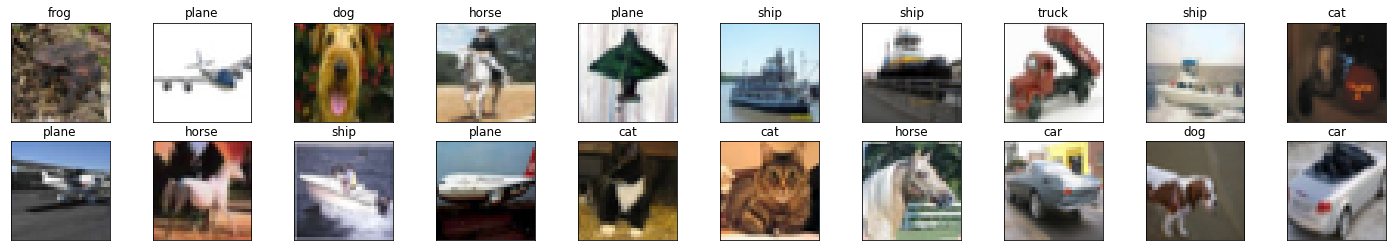

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  #print(labels[idx].item())
  ax.set_title(classes[labels[idx].item()])

Test 1: Train LeNET model from MNIST to check how it performs with CIFAR

In [11]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 20, 5, 1)           #number of input channels, number of output channels, kernel size, stride length
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(5*5*50, 500)
    self.drop1 = nn.Dropout(0.5)                  #dropout to prevent overfitting
    self.fc2 = nn.Linear(500, 10)


  def forward(self, x):
    L1 = F.relu(self.conv1(x))
    P1 = F.max_pool2d(L1, 2, 2)
    L2 = F.relu(self.conv2(P1))
    P2 = F.max_pool2d(L2, 2, 2)
    fi = P2.view(-1, 5*5*50)
    f1 = F.relu(self.fc1(fi))
    d1 = self.drop1(f1)
    #we can omit softmax here since we will use crossentropy as loss criterion
    #and it's implementation in pytorch already implements softmax
    f2  = self.fc2(d1)
    return f2

In [12]:
model = LeNet().to(device) 
model

LeNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1250, out_features=500, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [14]:
epochs = 15
losses = []
accuracy = []
val_losses = []
val_accuracies = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_loss = 0.0
  val_accuracy = 0.0

  for images, labels in training_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)   
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_accuracy += torch.sum(preds == labels.data)
    running_loss += loss.item() 

  else:
    with torch.no_grad():       #because we dont have to perform gradients for validation set
      for val_images, val_labels in validation_loader:
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_images)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_accuracy += torch.sum(val_preds == val_labels.data)
        val_loss += val_loss.item() 
    #metrics for training data
    epoch_loss = running_loss/len(training_loader)
    epoch_accuracy = running_accuracy.float()/len(training_loader)
    losses.append(epoch_loss)
    accuracy.append(epoch_accuracy)
    #metrics for validation data
    val_epoch_loss = val_loss/len(validation_loader)
    val_epoch_accuracy = val_accuracy.float()/len(validation_loader)
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    #print the training and validation metrics
    print("epoch:", e+1)
    print('training loss: {:.6f}, acc {:.6f}'.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.6f}, acc {:.6f}'.format(val_epoch_loss, val_epoch_accuracy.item()))

epoch: 1
training loss: 1.844762, acc 33.058002
validation loss: 0.031626, acc 41.340000
epoch: 2
training loss: 1.555364, acc 43.800003
validation loss: 0.030873, acc 46.369999
epoch: 3
training loss: 1.447463, acc 47.970001
validation loss: 0.029184, acc 49.289997
epoch: 4
training loss: 1.367894, acc 50.922001
validation loss: 0.027332, acc 51.750000
epoch: 5
training loss: 1.302180, acc 53.480003
validation loss: 0.027320, acc 53.969997
epoch: 6
training loss: 1.247709, acc 55.656002
validation loss: 0.024849, acc 55.669998
epoch: 7
training loss: 1.201307, acc 57.590004
validation loss: 0.024663, acc 56.849998
epoch: 8
training loss: 1.159220, acc 58.936005
validation loss: 0.023820, acc 58.299999
epoch: 9
training loss: 1.122487, acc 60.440002
validation loss: 0.023823, acc 59.109997
epoch: 10
training loss: 1.090333, acc 61.450005
validation loss: 0.022665, acc 61.119999
epoch: 11
training loss: 1.059752, acc 62.716003
validation loss: 0.022268, acc 61.239998
epoch: 12
training 

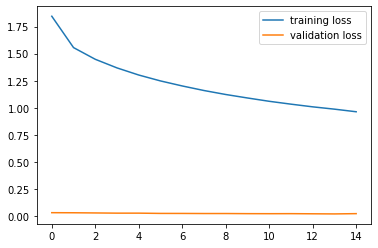

In [15]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.legend()

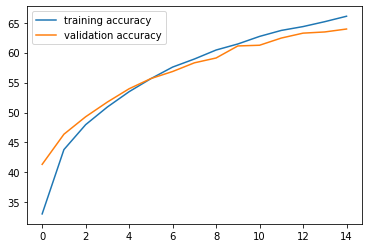

In [16]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

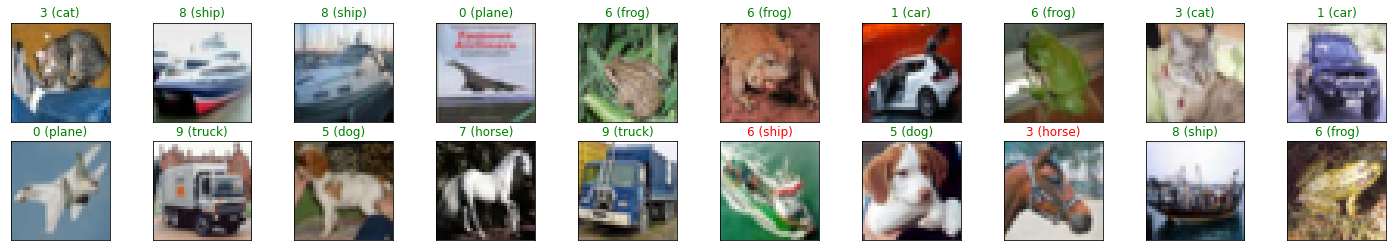

In [21]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))